## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [ ]:
import numpy as np
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
def gini(sequence):
  clss = {}
  for i in sequence:
    if(clss.get(i) == None):
      clss[i] = 1
    else:
      clss[i] += 1
  gini = 1
  for key in clss.keys():
    gini -= clss[key]/len(sequence) * clss[key]/len(sequence)
  return gini

def entropy(sequence):
  clss = {}
  for i in sequence:
    if(clss.get(i) == None):
      clss[i] = 1
    else:
      clss[i] += 1
  entropy = 0
  for key in clss.keys():
    entropy -= clss[key]/len(sequence) * np.log2(clss[key]/len(sequence))
  return entropy

In [ ]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [ ]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [ ]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [ ]:
import pandas as pd
# %pip install pandas-stubs
train_df = pd.read_csv('https://raw.githubusercontent.com/NCTU-VRDL/CS_CS20024/main/HW3/train.csv')
val_df = pd.read_csv('https://raw.githubusercontent.com/NCTU-VRDL/CS_CS20024/main/HW3/val.csv')

X = train_df.drop(labels=["price_range"], axis="columns")

feature_names = X.columns.values
X = X.values
Y = train_df['price_range'].values

X_test = val_df.drop(labels=["price_range"], axis="columns")
X_test = X_test.values
Y_test = val_df['price_range'].values
print(feature_names.shape , X.shape , Y.shape , X_test.shape , Y_test.shape)
train_df.head()

(20,) (1200, 20) (1200,) (300, 20) (300,)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [ ]:
import random
def unique_vals(rows_till_now , col , interpolated = False): # rows till now : row id till now , a list of ids
  global X
  uniqs = set()                               # x_data : a list  ; col : a number
  if not interpolated:
    for row in rows_till_now:
      uniqs.add(X[row][col])
  else:
    uniqs_ = {}
    for row in rows_till_now:
      val = X[row][col]
      if uniqs_.get(val):continue
      else:uniqs_[val] = 1
    uniqss_ = sorted(uniqs_.keys())
    for i in range(len(uniqss_)):
      if i == 0 :
        uniqs.add(uniqss_[i])
      else :
        uniqs.add( (uniqss_[i] + uniqss_[i-1]) / 2.0 )
  return list(uniqs)

def match(input , col , threshold , is_binary): # 對於第col個的feature , 檢驗input值是否符合threshold , 丟入col的原因是為了檢察是不是binary column(either 0 or 1)
  if not is_binary:
    if input >= threshold: 
      return True
    else:
      return False
  else:
    if input == threshold:
      return True
    else:
      return False 

def partition(rows_till_now , labels_till_now , col , criteria , is_binary): # 根據資料集中的某一特定col的值是否>=criteria(如果是binary col , >= 變成 ==)來拆分資料集(rows_till_now , labels_till_now)
  global X
  true_rows = []
  false_rows = []

  true_labels = []
  false_labels = []

  for i , row in enumerate(rows_till_now):
    if match(X[row][col] , col , criteria , is_binary) :
      true_rows.append(row)
      true_labels.append(labels_till_now[i])
    else :
      false_rows.append(row)
      false_labels.append(labels_till_now[i])
  return true_rows , true_labels , false_rows , false_labels 

def information_gain(true_rows , true_labels , false_rows , false_labels , current_impurity , criterion): # 根據拆分結果算information gain , 要傳criterion是因為不同棵樹可能有不同的評斷impurity的標準
  weight = len(true_rows) / (len(true_rows) + len(false_rows)) * 1.0
  info_gain = current_impurity
  if criterion == 'gini' :
    info_gain -= weight * gini(true_labels) + (1 - weight) * gini(false_labels)
  else :
    info_gain -= weight * entropy(true_labels) + (1 - weight) * entropy(false_labels)

  return info_gain

def find_best_split(rows_till_now , labels_till_now , criterion , total_features , random_): # 根據此棵樹給定的impurity criterion , 再資料集中各個col選出一個最好的作為拆分準則
  features = []
  if random_ == total_features:
    for i in range(total_features):
      features.append(i)
  else :
    ll = []
    for i in range(total_features):
      ll.append(i)
    picked = random.sample(ll , random_)
    features = picked

  current_impurity = 0.0
  
  if criterion == 'gini':
    current_impurity = gini(labels_till_now)
  else:
    current_impurity = entropy(labels_till_now)

  best_gain = 0 
  best_feature_id = 0
  best_value = 0
  best_isbinary = None

  for f in features:  # iterate through every feature , i表試著拿第幾個feature做拆分標準
    # print(features[i])
    vals = unique_vals(rows_till_now , f , False) # 當前這份資料集中 , 第i個feature的所有特殊元素
    is_binary = False
    if len(vals) == 2:
      is_binary = True
    for val in vals:
      criteria = val
      true_rows, true_labels , false_rows , false_labels = partition(rows_till_now , labels_till_now , f , criteria , is_binary)
      # print(len(true_rows) , len(false_rows))
      if len(true_rows) == 0 or len(false_rows) == 0: # 無用的拆分 , 意即根本沒辦法分群的一個條件組合
        # print(f"split using {features[i]} with {criteria} is unuseful")
        continue
      gain = information_gain(true_rows , true_labels , false_rows , false_labels , current_impurity , criterion) 
      if gain >= best_gain:
        best_gain = gain
        best_feature_id = f
        best_value = criteria
        best_isbinary = is_binary
  return best_feature_id , best_value , best_gain , best_isbinary
  
def is_leaf(depth , max_depth , best_gain , expected = None): 
  if best_gain == 0:
    return True
  if expected != None:
    if best_gain < expected:
      return True
  if max_depth != None:
    if depth == max_depth:
      return True
  return False

In [ ]:
class Decision_Node():
  def __init__(self , question_col , threshold , true_branch , false_branch , depth , isbinary):
      self.question_col = question_col
      self.threshold = threshold
      self.true_branch = true_branch
      self.false_branch = false_branch
      self.depth = depth
      self.isbinary = isbinary

class Leaf_Node():
  def __init__(self , zero_prob , one_prob , depth):
      self.zero_prob = zero_prob
      self.one_prob = one_prob
      self.depth = depth

In [ ]:
class DecisionTree():
  def __init__(self, criterion='gini', max_depth = None , random_ = 0):
      self.criterion = criterion
      self.max_depth = max_depth
      self.random_ = random_
      
      self.root_node = None
      self.feature_importance = {}

  def fit(self, x_data, y_data): 
    global X
    global Y
    X = x_data
    Y = y_data
    rows_till_now = [i for i in range(len(x_data))]
    labels_till_now = y_data
    if self.random_ == 0:
      self.random_ = x_data.shape[1]
    self.root_node = self.build_tree(rows_till_now , labels_till_now , 0)
         
  def predict(self, x_data):
      predictions = []
      for i in range(len(x_data)):
        pred = self.traverse(self.root_node , x_data[i])
        predictions.append(pred)
      return np.array(predictions)

  def build_tree(self , rows_till_now , labels_till_now , depth) :
      global X
      best_feature_id , best_value , best_gain , best_isbinary = find_best_split(
      rows_till_now , labels_till_now , self.criterion , X.shape[1] , self.random_)
      if is_leaf(depth , self.max_depth , best_gain) : # if it is a leaf node condition , create a leaf_node and then return its reference to its parent
        is_zero = 0
        is_one = 0
        for label in labels_till_now:
          if label : is_one += 1
          else : is_zero += 1
        zero_prob = is_zero/(is_zero + is_one)*1.0
        one_prob = 1 - zero_prob
        return Leaf_Node(zero_prob , one_prob , depth)
      
      true_rows , true_labels , false_rows , false_labels = partition(rows_till_now , labels_till_now , best_feature_id , best_value , best_isbinary) 
      true_branch = self.build_tree(true_rows , true_labels , depth+1) # extend true branch
      false_branch = self.build_tree(false_rows , false_labels , depth+1) # extend false branch
      return Decision_Node(best_feature_id , best_value , true_branch, false_branch , depth , best_isbinary) # create a decision_node
    
  def traverse(self , cur_node , a_row_x_data):  # determine a row of data belongs to where
      if isinstance(cur_node , Leaf_Node): 
        return int(cur_node.one_prob > cur_node.zero_prob)
      
      question_col = cur_node.question_col 
      threshold = cur_node.threshold
      input = a_row_x_data[question_col]
      if match(input , question_col , threshold , cur_node.isbinary):
        return self.traverse(cur_node.true_branch , a_row_x_data)
      else:
        return self.traverse(cur_node.false_branch , a_row_x_data)

  def DFS(self , cur_node):
    if isinstance(cur_node , Leaf_Node) :
      return 
    if self.feature_importance.get(cur_node.question_col) == None:
      self.feature_importance[cur_node.question_col] = 1
    else:
      self.feature_importance[cur_node.question_col] += 1
    self.DFS(cur_node.true_branch)
    self.DFS(cur_node.false_branch)

  def print_tree(self , node, spacing=""):
    # Base case: we've reached a leaf
    if isinstance(node, Leaf_Node):
        print (spacing +"is leaf")
        return

    # Print the question at this node
    print (spacing + str(node.question_col) + ' ' + str(node.threshold) , node.depth)

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    self.print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    self.print_tree(node.false_branch, spacing + "  ")

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [ ]:
from sklearn.metrics import accuracy_score

from sklearn import tree

clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

clf_depth3.fit(X , Y)
predictions = clf_depth3.predict(X_test)
print("Accuracy using clf_depth3 on validation data : " , accuracy_score(Y_test , predictions))

# clf = tree.DecisionTreeClassifier(max_depth = 3)
# clf = clf.fit(X, Y)
# predictions = clf.predict(X_test)
# print("Accuracy using sklearn clf_depth3 on validation data : " , accuracy_score(Y_test , predictions))

clf_depth10.fit(X , Y)
predictions = clf_depth10.predict(X_test)
print("Accuracy using clf_depth10 on validation data : " , accuracy_score(Y_test , predictions))

# clf = tree.DecisionTreeClassifier(max_depth = 10)
# clf = clf.fit(X, Y)
# predictions = clf.predict(X_test)
# print("Accuracy using sklearn clf_depth10 on validation data : " , accuracy_score(Y_test , predictions))


Accuracy using clf_depth3 on validation data :  0.92
Accuracy using clf_depth10 on validation data :  0.9433333333333334


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [ ]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)

clf_gini.fit(X , Y)
predictions = clf_gini.predict(X_test)
print("Accuracy using clf_gini on validation data : " , accuracy_score(Y_test , predictions))

# clf = tree.DecisionTreeClassifier(criterion = 'gini' , max_depth = 3)
# clf = clf.fit(X, Y)
# predictions = clf.predict(X_test)
# print("Accuracy using sklearn clf_gini on validation data : " , accuracy_score(Y_test , predictions))

clf_entropy.fit(X , Y)
predictions = clf_entropy.predict(X_test)
print("Accuracy using clf_entropy on validation data : " , accuracy_score(Y_test , predictions))

# clf = tree.DecisionTreeClassifier(criterion = 'entropy' , max_depth = 3)
# clf = clf.fit(X, Y)
# predictions = clf.predict(X_test)
# print("Accuracy using sklearn clf_entropy on validation data : " , accuracy_score(Y_test , predictions))


Accuracy using clf_gini on validation data :  0.92
Accuracy using clf_entropy on validation data :  0.9333333333333333


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

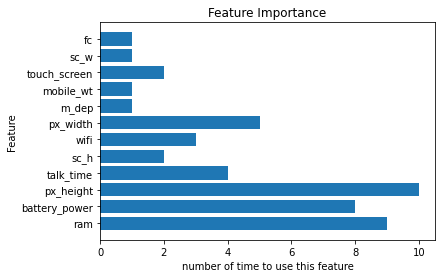

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

clf_depth10.DFS(clf_depth10.root_node)
fimportance = clf_depth10.feature_importance
# print(fimportance)
features = list(fimportance.keys())
feature_names_ = []
for i in range(len(features)):
  feature_names_.append(feature_names[features[i]])
time = list(fimportance.values())
plt.barh(feature_names_ , time)
plt.ylabel('Feature')
plt.xlabel('number of time to use this feature')
plt.title('Feature Importance')
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [ ]:
import math
class AdaBoost():
    def __init__(self, n_estimators , max_depth = None):
        self.n_estimators = n_estimators
        self.classifier_weight = []
        self.each_tree_max_depth = max_depth
        self.roots = []
    
    def fit(self, x_data, y_data):
      global X
      global Y

      X = x_data
      Y = y_data

      x_origin = X
      y_origin = Y

      data_weight_ = []
      for i in range(len(x_data)):
        data_weight_.append(1.0 * 1/x_data.shape[0])
    
      for t in range(self.n_estimators):
        # print(prev == data_weight_)
        best_weak_classifier = DecisionTree(max_depth = self.each_tree_max_depth)
        chosen_rows = np.random.choice(len(x_data), len(x_data), p = data_weight_)
        xx_data = []
        yy_data = []
        for row in chosen_rows:
          xx_data.append(x_data[row])
          yy_data.append(y_data[row])

        best_weak_classifier.fit(np.array(xx_data) , yy_data)
        self.roots.append(best_weak_classifier.root_node)
        # print(best_weak_classifier.root_node.question , best_weak_classifier.root_node.threshold)
        predictions = best_weak_classifier.predict(x_data)
        weighted_err = 0
        for i , pred in enumerate(predictions):
          if pred != y_data[i]:
            weighted_err += data_weight_[i]
        self.classifier_weight.append( 0.5 * np.log( (1-weighted_err) / (weighted_err + 1e-9)) )
        

        for i in range(len(data_weight_)):
          if y_data[i] == predictions[i]:
            data_weight_[i] *= math.exp(-1.0 * self.classifier_weight[t])
          else :
            data_weight_[i] *= math.exp(1.0 * self.classifier_weight[t])
        sum_ = sum(data_weight_)
        for i , w in enumerate(data_weight_):
          data_weight_[i] = 1.0 * w/sum_

        X = x_origin
        Y = y_origin
                

    def traverse(self , cur_node , a_row_x_data):  # determine a row of data belongs to where
      if isinstance(cur_node , Leaf_Node): 
        return int(cur_node.one_prob >= cur_node.zero_prob)
      
      question_col = cur_node.question_col 
      threshold = cur_node.threshold
      input = a_row_x_data[question_col]
      if match(input , question_col , threshold , cur_node.isbinary):
        return self.traverse(cur_node.true_branch , a_row_x_data)
      else:
        return self.traverse(cur_node.false_branch , a_row_x_data)

    def predict(self, x_data):
      predictions = []
      for i in range(x_data.shape[0]):
        Hofx = 0.0
        for t , root in enumerate(self.roots):
          pred = self.traverse(root , x_data[i])  #定義label 0 給定 -1 ; label 1 給定 +1
          if pred : 
            Hofx += 1.0 * self.classifier_weight[t]
          else : 
            Hofx += -1.0 * self.classifier_weight[t]
        predictions.append(int(Hofx > 0.0))
        # print(f"Total {self.n_estimators} , {is_0} says 0 ; {is_1} says 1 , ")
      return np.array(predictions)

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

clf_adaboost10 = AdaBoost(n_estimators = 10 , max_depth = 1)
clf_adaboost100 = AdaBoost(n_estimators = 100 , max_depth = 1)

clf_adaboost10.fit(X , Y)
predictions = clf_adaboost10.predict(X_test)
print("Accuracy using clf_adaboost10 on validation data : " , accuracy_score(Y_test , predictions))


# clf = AdaBoostClassifier(n_estimators=10)
# clf.fit(X , Y)
# predictions = clf.predict(X_test)
# print("Accuracy using sklearn clf_adaboost10 on validation data : " , accuracy_score(Y_test , predictions))

clf_adaboost100.fit(X , Y)
predictions = clf_adaboost100.predict(X_test)
print("Accuracy using clf_adaboost100 on validation data : " , accuracy_score(Y_test , predictions))

# clf = AdaBoostClassifier(n_estimators=100)
# clf.fit(X , Y)
# predictions = clf.predict(X_test)
# print("Accuracy using sklearn clf_adaboost100 on validation data : " , accuracy_score(Y_test , predictions))

Accuracy using clf_adaboost10 on validation data :  0.91
Accuracy using clf_adaboost100 on validation data :  0.9666666666666667


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [ ]:
import random
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap = True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = int(max_features)
        self.boostrap = boostrap
        self.criterion = criterion
        self.each_tree_max_depth = max_depth
        self.roots = []

    def Bagging(self , x_data , y_data):
      if not self.boostrap:
        return np.array(x_data) , np.array(y_data)
      bag_x_data = []
      bag_y_data = []
      for i in range(len(x_data)):
        picked = random.randint(0,len(x_data)-1)
        bag_x_data.append(x_data[picked])
        bag_y_data.append(y_data[picked])
      return np.array(bag_x_data) , np.array(bag_y_data)
    
    def Create_decision_tree(self , x_data , y_data):
      clf = DecisionTree(criterion=self.criterion , max_depth = self.each_tree_max_depth , random_ = self.max_features)
      clf.fit(x_data , y_data)
      self.roots.append(clf.root_node)

    def fit(self, x_data, y_data):
        global X
        global Y

        X = x_data
        Y = y_data

        x_origin = X
        y_origin = Y

        for time in range(self.n_estimators):
          ax_data , ay_data = self.Bagging(x_data , y_data)
          self.Create_decision_tree(ax_data , ay_data)
          X = x_origin
          Y = y_origin
        
    def predict(self, x_data):
        predictions = []
        for i in range(len(x_data)):
          is_one = 0
          is_zero = 0
          for root in self.roots:
            pred = self.traverse(root , x_data[i])
            if pred : is_one+=1
            else : is_zero+=1
          predictions.append(int(is_one > is_zero))
        return np.array(predictions)

    def traverse(self , cur_node , a_row_x_data):  # determine a row of data belongs to where
      if isinstance(cur_node , Leaf_Node): 
        return int(cur_node.one_prob > cur_node.zero_prob)
      
      question_col = cur_node.question_col 
      threshold = cur_node.threshold
      input = a_row_x_data[question_col]
      if match(input , question_col , threshold , cur_node.isbinary):
        return self.traverse(cur_node.true_branch , a_row_x_data)
      else:
        return self.traverse(cur_node.false_branch , a_row_x_data)

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf_10tree = RandomForest(n_estimators=10, max_features = np.sqrt(len(feature_names)))
clf_100tree = RandomForest(n_estimators=100, max_features = np.sqrt(len(feature_names)))


clf_10tree.fit(X , Y)
predictions = clf_10tree.predict(X_test)
print("Accuracy using clf_10 on validation data : " , accuracy_score(Y_test , predictions))

clf_100tree.fit(X , Y)
predictions = clf_100tree.predict(X_test)
print("Accuracy using clf_100 on validation data : " , accuracy_score(Y_test , predictions))

# clf = RandomForestClassifier(n_estimators=10)
# clf.fit(X, Y)
# predictions = clf.predict(X_test)
# print("Accuracy using sklearn clf_10 on validation data : " , accuracy_score(Y_test , predictions))

# clf = RandomForestClassifier(n_estimators=100)
# clf.fit(X, Y)
# predictions = clf.predict(X_test)
# print("Accuracy using sklearn sklearn clf_100 on validation data : " , accuracy_score(Y_test , predictions))

Accuracy using clf_10 on validation data :  0.9333333333333333
Accuracy using clf_100 on validation data :  0.9366666666666666


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [ ]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(len(feature_names)))
clf_all_features = RandomForest(n_estimators=10, max_features=len(feature_names))

clf_random_features.fit(X , Y)
predictions = clf_random_features.predict(X_test)
print("Accuracy using clf_random_features on validation data : " , accuracy_score(Y_test , predictions))

clf_all_features.fit(X , Y)
predictions = clf_all_features.predict(X_test)
print("Accuracy using clf_all_features on validation data : " , accuracy_score(Y_test , predictions))

Accuracy using clf_random_features on validation data :  0.9133333333333333
Accuracy using clf_all_features on validation data :  0.9566666666666667


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [ ]:
def train_your_model(data): 
  '''
   因為用global寫 , 所以重複執行某個cell block會導致資料集不一致(或是index out of range等)!!!
   請重頭跑到尾run all一次整份程式即可。

   在這整份作業中我對資料集的操作都是用global的原因是避免資料要在object
   中傳遞會每次都要copy一份 , 這樣很耗時間 , 所以乾脆利用程式執行順序去每次改一個全域變數 , 不同object創立後都會去看同一個名字的全域變數 , 但是不同時間點這個變數的資料集內容會不同
   ex:在adaboost中每一輪因為要依據各筆資料的weight sample 原本丟進fit的原始資料集 , 所以可能在每一個找weak classifier的round時 , 這份全域資料集X,Y會先變成那份新sample的資料集以提供給各函數做操作 , 在結束
   此輪後又會把這個全域資料集X,Y改回丟進fit的原始資料集 , 這樣下一輪又要根據各筆資料的weight sample時 , 看的才會是同一份丟進fit裡面的原始資料集

   而在每次fit的時候都會用傳入的data改寫那個全域變數 , 所以可以保證正確的程式執行
  '''
  global X
  global Y

  XplusXtest = []
  YplusYtest = []
  for i in X:
    XplusXtest.append(i)
  for i in Y:
    YplusYtest.append(i)
  for i in X_test:
    XplusXtest.append(i)
  for i in Y_test:
    YplusYtest.append(i)

  clf_adaboost150 = AdaBoost(n_estimators = 150 , max_depth = 1)
  # print(np.array(XplusXtest).shape , np.array(YplusYtest).shape)
  clf_adaboost150.fit(np.array(XplusXtest) , np.array(YplusYtest))
  return clf_adaboost150

In [ ]:
my_model = train_your_model(train_df)

KeyboardInterrupt: ignored

In [ ]:
y_pred = my_model.predict(x_test)

In [ ]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

In [ ]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")

*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
